# Import Libraries

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors, KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
from os import listdir
from datetime import timedelta
import plotly.express as px
from matplotlib import ticker

# Data Ingestion and Formatting

In [2]:
# concatenate all data
files = [f for f in listdir('csse_covid_19_data/csse_covid_19_daily_reports/')]

all_data = pd.DataFrame()

for file in files:
    # skip non-data files
    if '.csv' not in file:
        print('skip {}'.format(file))
        continue
    
    print('starting {}'.format(file))
    data = pd.read_csv('csse_covid_19_data/csse_covid_19_daily_reports/{}'.format(file))
    
    # insert date column based on file name
    data['date'] = file.split(".")[0]
    
    # rename columns given file changes over time
    data.rename(columns={'Province/State':'Province_State', 'Country/Region': 'Country_Region', 'Admin2': 'City'}, inplace=True)
    
    all_data = pd.concat([all_data, data])
    
# filter to only relevant columns
all_data = all_data[['date','Country_Region','Province_State', 'City', 'Confirmed', 'Deaths', 'Recovered']]

starting 02-26-2020.csv
starting 02-27-2020.csv
starting 04-08-2020.csv
starting 04-09-2020.csv
starting 02-18-2020.csv
starting 02-19-2020.csv
starting 03-24-2020.csv
starting 03-25-2020.csv
starting 04-02-2020.csv
starting 04-03-2020.csv
starting 03-10-2020.csv
starting 03-11-2020.csv


/opt/anaconda3/envs/plotly/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




starting 02-12-2020.csv
starting 02-13-2020.csv
starting 03-07-2020.csv
starting 03-06-2020.csv
starting 04-15-2020.csv
starting 04-14-2020.csv
starting 02-05-2020.csv
starting 02-04-2020.csv
starting 02-08-2020.csv
starting 02-09-2020.csv
starting 03-01-2020.csv
starting 04-12-2020.csv
starting 04-13-2020.csv
starting 02-02-2020.csv
starting 02-03-2020.csv
starting 01-31-2020.csv
starting 01-30-2020.csv
starting 02-21-2020.csv
starting 02-20-2020.csv
starting 03-23-2020.csv
starting 03-22-2020.csv
starting 04-05-2020.csv
starting 04-04-2020.csv
starting 03-17-2020.csv
starting 03-16-2020.csv
starting 02-15-2020.csv
starting 02-14-2020.csv
starting 01-26-2020.csv
starting 01-27-2020.csv
starting 03-29-2020.csv
starting 03-28-2020.csv
starting 03-04-2020.csv
skip README.md
starting 03-05-2020.csv
starting 02-06-2020.csv
starting 02-07-2020.csv
skip .gitignore
starting 03-30-2020.csv
starting 03-31-2020.csv
starting 04-01-2020.csv
starting 03-13-2020.csv
starting 03-12-2020.csv
starting 

In [3]:
# data cleaning due to inconsistent column nomenclature in raw data
renaming_dictionary = {
    'China': ['Mainland China'],
    'South Korea': ['Korea, South', 'Republic of Korea'],
    'Iran': ['Iran (Islamic Republic of)'],
    'Taiwan': ['Taipei and environs', 'Taiwan*'],
    'Vietnam': ['Viet Nam'],
    'Ireland': ['Republic of Ireland'],
    'Hong Kong': ['Hong Kong SAR'],
}

for k,v in renaming_dictionary.items():
    all_data.replace(to_replace=v, value=k, inplace=True)


all_data.head(5)

,date,Country_Region,Province_State,City,Confirmed,Deaths,Recovered
0,02-26-2020,China,Hubei,NaN,65187.0,2615.0,20969.0
1,02-26-2020,China,Guangdong,NaN,1347.0,7.0,851.0
2,02-26-2020,China,Henan,NaN,1271.0,19.0,1033.0
3,02-26-2020,South Korea,NaN,NaN,1261.0,12.0,22.0
4,02-26-2020,China,Zhejiang,NaN,1205.0,1.0,867.0


# Data Exploration at Country Level

In [4]:
# generate agg_sum dataframe which shows cumulative confirmed cases by country
agg_sum = all_data.groupby(['Country_Region', 'date'],as_index=False)['Confirmed'].agg('sum')
agg_sum = agg_sum.groupby(['Country_Region'],as_index=False)['Confirmed'].agg('max')
agg_sum.sort_values('Confirmed', ascending = False, inplace=True)
agg_sum.iloc[0:15]

,Country_Region,Confirmed
210,US,636350.0
191,Spain,177644.0
103,Italy,165155.0
72,France,137875.0
78,Germany,134753.0
214,United Kingdom,99483.0
42,China,83356.0
99,Iran,76389.0
208,Turkey,69392.0
19,Belgium,33573.0


<function matplotlib.pyplot.show(*args, **kw)>

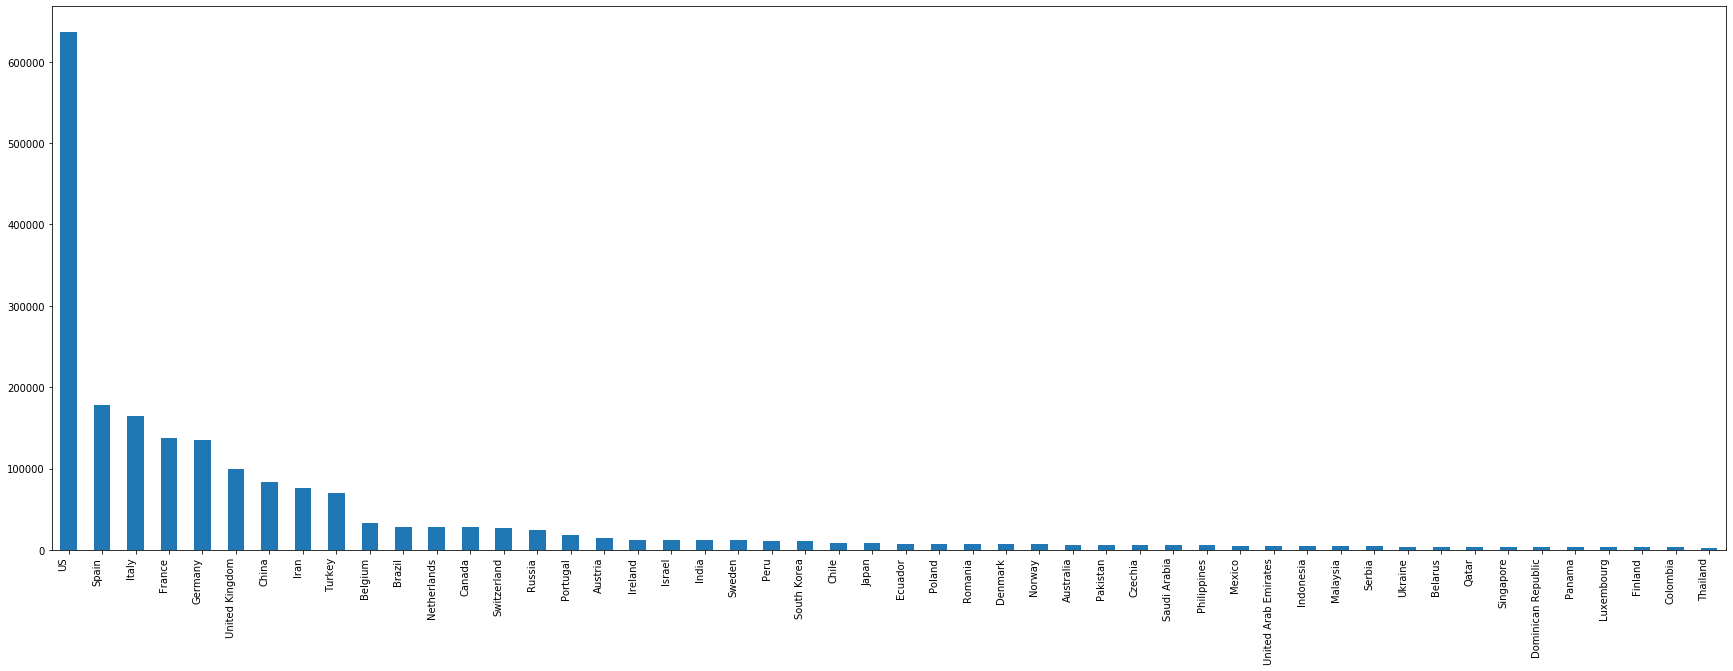

In [5]:
# visual plot of CONFIRMED cases by top 50 country
axis = agg_sum.iloc[0:50]['Confirmed'].plot(kind='bar', label='Country', figsize=(30,10))
axis.set_xticklabels(labels=agg_sum['Country_Region'], rotation=90, ha='right')

plt.show

#fig = px.bar(agg_sum.iloc[0:50], x='Country_Region', y="Confirmed", text="Confirmed", 
#             height=500, width=1000, template="simple_white")
#fig.show()

In [6]:
# function to generate day change features
def generate_features(dataframe, groupby):
    dataframe['Confirmed_lag_1_day'] = dataframe.groupby(["{}".format(groupby)])['Confirmed'].shift(1)
    dataframe['Day_Change'] = dataframe['Confirmed'] - dataframe['Confirmed_lag_1_day']
    dataframe['Day_Change_Percent'] = dataframe['Day_Change'] / dataframe['Confirmed_lag_1_day']
    return dataframe

In [7]:
# filter to select country data
select_country_data = all_data[all_data['Country_Region'].isin(['US', 'Italy', 'Spain', 'China', 'Germany', 'France', 'South Korea', 'Iran', 'Taiwan', 'Singapore'])]
select_country_data = select_country_data[(select_country_data.date > '03-01-2010')]
agg_select_country_data = select_country_data.groupby(['Country_Region', 'date'],as_index=False).agg({'Confirmed':'sum'}).reset_index()
agg_select_country_data.sort_values(by=['date'],ascending=True, inplace=True)

# generate additional features
agg_select_country_data = generate_features(agg_select_country_data, 'Country_Region')

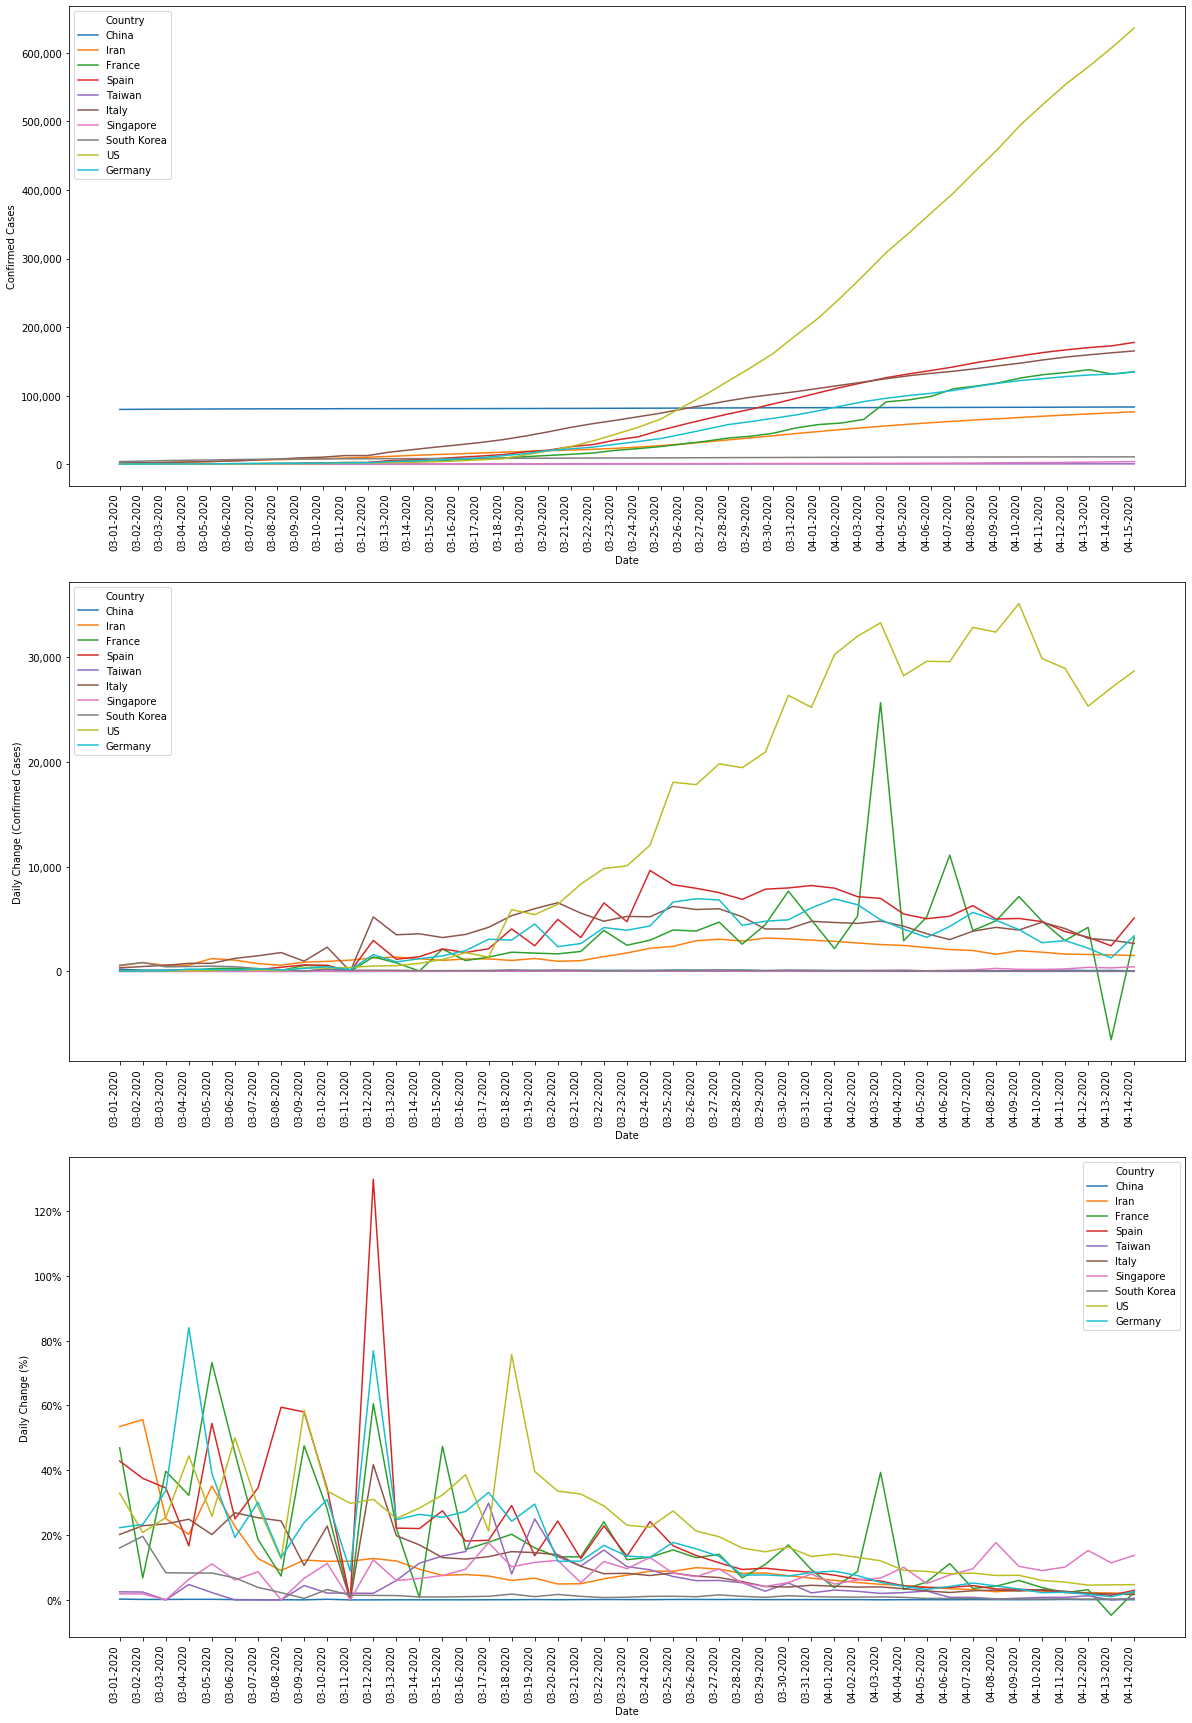

In [8]:
# Visualization of select country trends
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20,30))

fig1 = sns.lineplot(x="date", y="Confirmed", hue="Country_Region",
             data=agg_select_country_data, ax=ax1)
ax1.set_xticklabels(labels=agg_select_country_data['date'].unique(), rotation=90, ha='right')
ax1.set(xlabel='Date', ylabel='Confirmed Cases')
ax1.legend().texts[0].set_text("Country")
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.0f}'.format(y)))

sns.lineplot(x="date", y="Day_Change", hue="Country_Region",
             data=agg_select_country_data, ax=ax2)
ax2.set_xticklabels(labels=agg_select_country_data['date'].unique(), rotation=90, ha='right') 
ax2.set(xlabel='Date', ylabel='Daily Change (Confirmed Cases)')
ax2.legend().texts[0].set_text("Country")
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.0f}'.format(y)))

sns.lineplot(x="date", y="Day_Change_Percent", hue="Country_Region",
             data=agg_select_country_data, ax=ax3)
ax3.set_xticklabels(labels=agg_select_country_data['date'].unique(), rotation=90, ha='right') 
ax3.set(xlabel='Date', ylabel='Daily Change (%)')
ax3.legend().texts[0].set_text("Country")
ax3.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.0%}'.format(y)))

plt.show()

# Data Exploration of US State Level Data

In [9]:
# aggregate by state
US_data = all_data[all_data['Country_Region'].isin(['US'])]
US_state_data = US_data.groupby(['Province_State', 'date'],as_index=False).agg({'Confirmed':'sum'}).reset_index()
US_state_data = US_state_data[(~US_state_data['Province_State'].str.contains(",")) & (~US_state_data['Province_State'].str.contains("Princess"))]
US_state_data.sort_values(by=['date'],ascending=True, inplace=True)

# generate additional features
US_state_data = generate_features(US_state_data, 'Province_State').reset_index().drop(columns=['level_0', 'index'])

# Visualize
US_state_data[US_state_data['Province_State'] == 'New York']

,Province_State,date,Confirmed,Confirmed_lag_1_day,Day_Change,Day_Change_Percent
31,New York,03-10-2020,173.0,NaN,NaN,NaN
101,New York,03-11-2020,220.0,173.0,47.0,0.271676
161,New York,03-12-2020,328.0,220.0,108.0,0.490909
212,New York,03-13-2020,421.0,328.0,93.0,0.283537
266,New York,03-14-2020,525.0,421.0,104.0,0.247031
288,New York,03-15-2020,732.0,525.0,207.0,0.394286
354,New York,03-16-2020,967.0,732.0,235.0,0.321038
423,New York,03-17-2020,1706.0,967.0,739.0,0.764219
477,New York,03-18-2020,2495.0,1706.0,789.0,0.462485
528,New York,03-19-2020,5365.0,2495.0,2870.0,1.150301


In [10]:
# method that returns top n-regions by sheer size of confirmed cases and by z-day growth rate
def top_n_display(data, groupby_column, n, z):
    # top n regions by sheer size
    cumulative_data = data.groupby("{}".format(groupby_column), as_index=False).agg({'Confirmed': 'max'})
    #print(cumulative_data.sort_values('Confirmed', ascending = False).head(n))
    top_regions_by_size = cumulative_data.sort_values('Confirmed', ascending = False)['Province_State'].tolist()
    
    # top n regions by average z-day growth rate
    CAGR_data = data
    CAGR_data["Confirmed_lag_{}_day".format(z)] = CAGR_data.groupby(["{}".format(groupby_column)])['Confirmed'].shift(z)
    CAGR_data["CAGR_{}_day".format(z)] = ((CAGR_data["Confirmed"] - CAGR_data["Confirmed_lag_{}_day".format(z)]) / CAGR_data["Confirmed_lag_{}_day".format(z)] + 1) ** (1/z) - 1
    CAGR_data = CAGR_data[CAGR_data['date'] == CAGR_data.agg({'date':'max'}).date]
    #print(CAGR_data[['Province_State', 'date', "CAGR_{}_day".format(z)]].sort_values("CAGR_{}_day".format(z), ascending = False).head(n))
    top_regions_by_CAGR = CAGR_data.sort_values("CAGR_{}_day".format(z), ascending = False)['Province_State'].tolist()
    
    # return results
    return top_regions_by_size[0:n], top_regions_by_CAGR[0:n]

a, b = top_n_display(US_state_data, 'Province_State', 10, 5)
print(a, b)

['New York', 'New Jersey', 'Massachusetts', 'Michigan', 'Pennsylvania', 'California', 'Illinois', 'Florida', 'Louisiana', 'Texas'] ['South Dakota', 'Rhode Island', 'Delaware', 'Virginia', 'Maryland', 'Iowa', 'Massachusetts', 'Nebraska', 'Connecticut', 'New Hampshire']


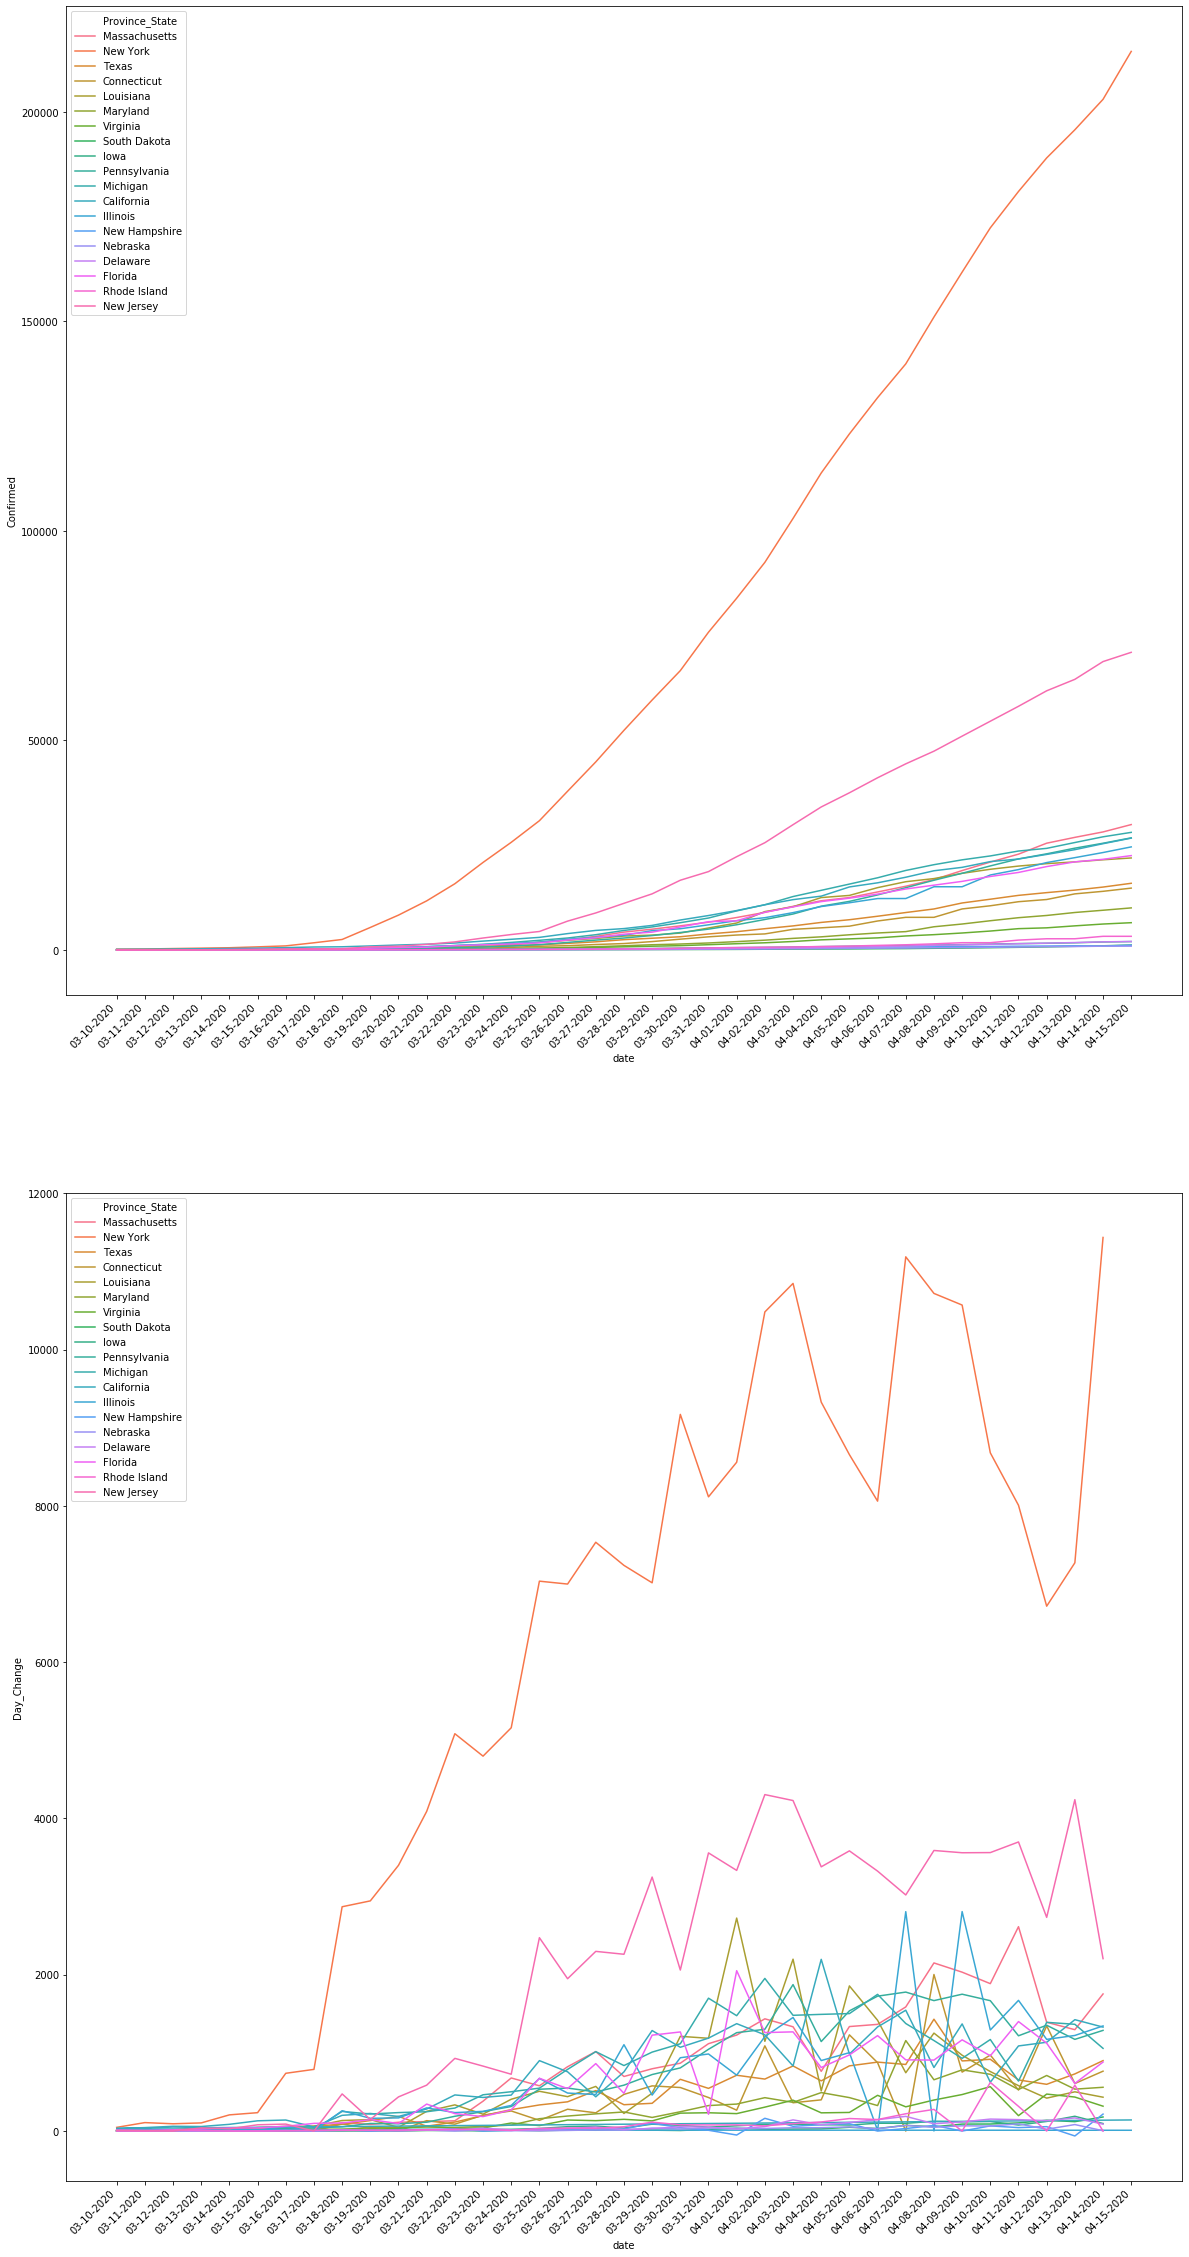

In [11]:
# Visualize trends for top states by volume and infection rate
top_states_data = US_state_data[US_state_data['Province_State'].isin(a+b)]
top_states_data = top_states_data[top_states_data.date > '03-01-2020']

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,40))

sns.lineplot(x="date", y="Confirmed",
             data=top_states_data, hue='Province_State', ax=ax1)
ax1.set_xticklabels(labels=top_states_data['date'].unique(), rotation=45, ha='right')

sns.lineplot(x="date", y="Day_Change",
             data=top_states_data, hue='Province_State', ax=ax2)
ax2.set_xticklabels(labels=top_states_data['date'].unique(), rotation=45, ha='right')

plt.show()

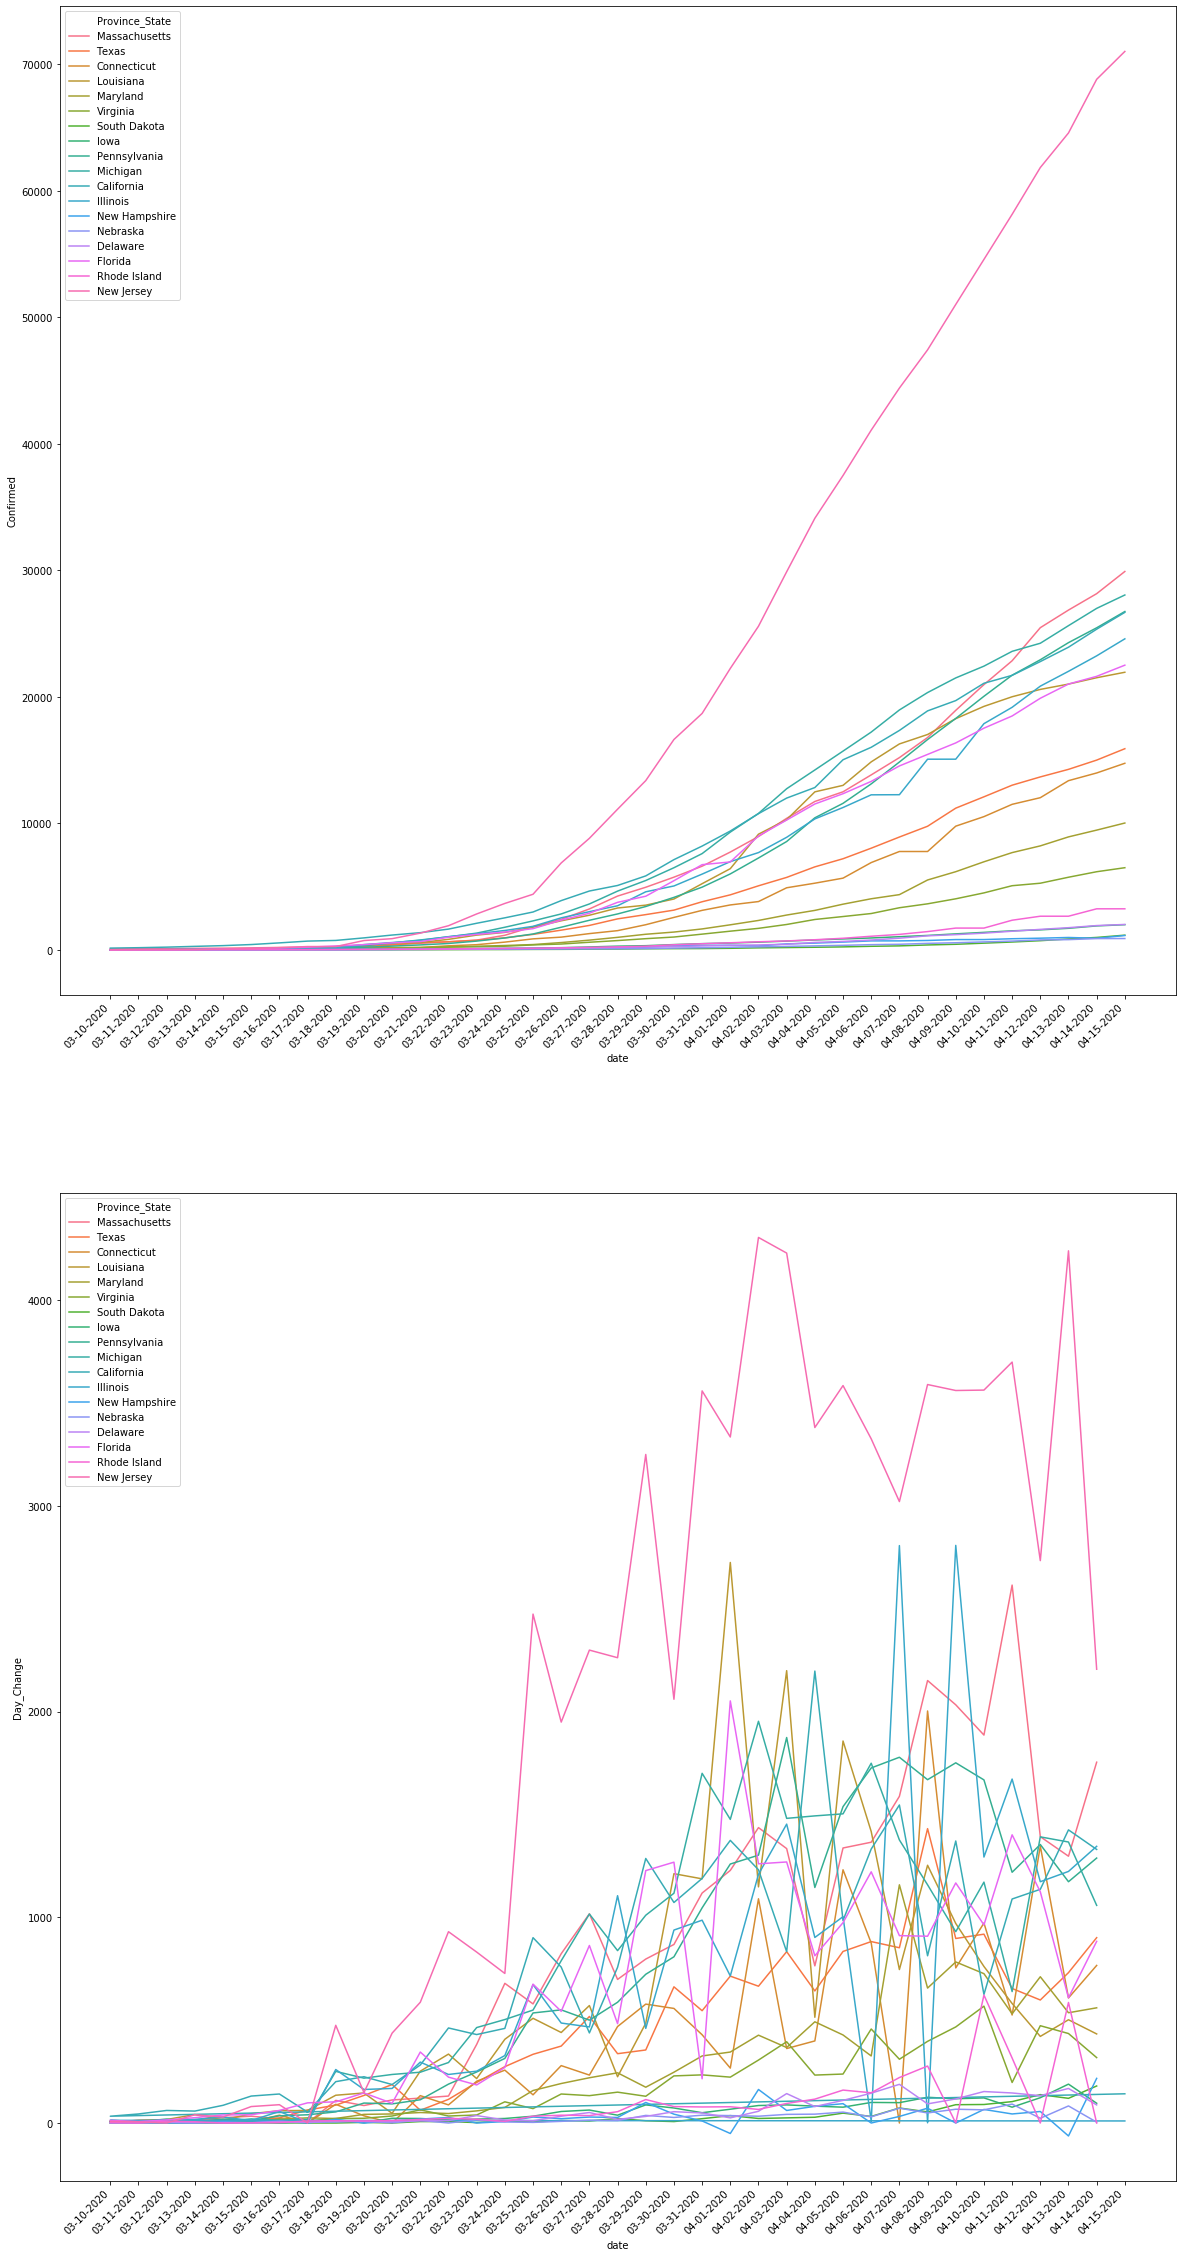

In [12]:
# Visualize trends for top states by volume and infection rate, remove NY
US_state_sans_NY_data = top_states_data[top_states_data['Province_State'] != 'New York']

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,40))

sns.lineplot(x="date", y="Confirmed",
             data=US_state_sans_NY_data, hue='Province_State', ax=ax1)
ax1.set_xticklabels(labels=US_state_sans_NY_data['date'].unique(), rotation=45, ha='right')

sns.lineplot(x="date", y="Day_Change",
             data=US_state_sans_NY_data, hue='Province_State', ax=ax2)
ax2.set_xticklabels(labels=US_state_sans_NY_data['date'].unique(), rotation=45, ha='right')

plt.show()

# KNN Algorithm Fitting at Country Level

In [27]:
# define variables
prediction_days = [1,2,3,4,5,6,7]    
trending_days = [3,5,7,14]
analysis_date = '04-05-2020'
list_of_states = list(set(US_state_data.Province_State.values.tolist()))

# define functions
# method to build out CAGR features
def cagr_features(data, groupby_column, days):
    data["Confirmed_lag_{}_day".format(days)] = data.groupby(["{}".format(groupby_column)])['Confirmed'].shift(days)
    data["CAGR_{}_day".format(days)] = ((data["Confirmed"] - data["Confirmed_lag_{}_day".format(days)]) / data["Confirmed_lag_{}_day".format(days)] + 1) ** (1/days) - 1
    data.drop(columns=["Confirmed_lag_{}_day".format(days)], inplace=True)
    return 

# add CAGR columns and filter data based on analysis date
def prep_data(orig_data, days):
    # copy data to prevent overwrite
    data = orig_data.copy(deep=True)
    
    # call method to build out CAGR features
    for day in days:
        cagr_features(data, 'Country_Region', day)
    
    # rename prediction column which is assumed to be last value in days list
    data.rename(columns={"CAGR_{}_day".format(days[-1]):"prediction_day_cagr"}, inplace=True)
    
    # filter out days with less than 14 days of historical data AND < prediction_days of future data  AND != US
    data = data[data["CAGR_{}_day".format(days[-2])].notnull() 
                & (data["CAGR_{}_day".format(days[-2])] != np.inf) 
                & data['prediction_day_cagr'].notnull() 
                & (data['prediction_day_cagr'] != np.inf)
                & (data['Country_Region'] != 'US')] \
        .reset_index().drop(columns=['index'])

    return data

# fit K-NN algorithm
def train_knn_data(data, scaler):
    # format data
    training_x_data = data.drop(columns=['Country_Region', 'date', 'prediction_day_cagr'])
    training_y_data = data['prediction_day_cagr']
    training_x_data['Confirmed'] = scaler.transform(training_x_data.Confirmed.values.reshape(-1,1))

    # fit algorithm
    model = KNeighborsRegressor(n_neighbors=10, weights='distance').fit(training_x_data, training_y_data)
    
    return model

# fit rf model
def train_rf_data(data, scaler):
    # format data
    training_x_data = data.drop(columns=['Country_Region', 'date', 'prediction_day_cagr'])
    training_y_data = data['prediction_day_cagr']
    training_x_data['Confirmed'] = scaler.transform(training_x_data.Confirmed.values.reshape(-1,1))

    # fit algorithm
    model = RandomForestRegressor(max_depth=20, random_state=0,n_estimators = 100).fit(training_x_data, training_y_data)
    
    return model

# prep training data
# sum data to daily level per country
nn_data = all_data.groupby(['Country_Region', 'date'], as_index=False).agg({'Confirmed': 'sum'})
# fit scaler
confirmed_scaler = preprocessing.MinMaxScaler().fit(nn_data.Confirmed.values.reshape(-1,1))

# prep test data
# build out features at state level
test_data = US_state_data.copy(deep=True)
for day in trending_days:
    cagr_features(test_data, 'Province_State', day)
test_data['Confirmed'] = confirmed_scaler.transform(test_data.Confirmed.values.reshape(-1,1))
test_data = test_data[["Confirmed"] + ["CAGR_{}_day".format(day) for day in trending_days]]

# build state dictionaries for test data lookup
zipped_state_columns = zip(US_state_data.index.tolist(), US_state_data.Province_State.tolist(), US_state_data.date.tolist())
state_index_to_key = {ind:(loc, date) for ind, loc, date in zipped_state_columns} 
state_key_to_index = {value: key for key, value in state_index_to_key.items()} 

In [28]:
predict_pd = pd.DataFrame()
knn_models = {}
database = {}

# fit KNN model to every country's confirmed cases and predict future confirmed cases for every state
for day in prediction_days:
    # considered set of days for CAGR
    set_of_days = trending_days + [-day]
    
    # format training data
    training_data = prep_data(nn_data, set_of_days)
    
    # build dictionaries for lookup
    zipped_columns = zip(training_data.index.tolist(), training_data.Country_Region.tolist(), training_data.date.tolist())
    index_to_key = {ind:(loc, date) for ind, loc, date in zipped_columns} 
    key_to_index = {value: key for key, value in index_to_key.items()} 
    
    # train model
    model= train_knn_data(training_data, confirmed_scaler)

    # predict growth rates for each state based on model
    growth_rates_dict = {}
    for state in list_of_states:
        try:
            value = model.predict([test_data.iloc[state_key_to_index[(state, analysis_date)]]])
            growth_rates_dict[state] = value[0]
        except Exception as e: 
            # print("Error: " + str(e))
            continue
    
    # predict confirmed case growth for every state
    for k,v in growth_rates_dict.items():
        t0_confirmed = US_state_data[(US_state_data.Province_State == k) & (US_state_data.date == analysis_date)].Confirmed.values[0]

        append_pd = pd.DataFrame([[analysis_date, k, t0_confirmed * (1+v)**(day), 'prediction']], columns = ['date', 'Province_State', 'Confirmed', 'type'])
        append_pd['date'] = append_pd.date.astype('datetime64[ns]')
        append_pd['date'] = append_pd.apply(lambda row: row.date + timedelta(days=day), axis=1)

        predict_pd = predict_pd.append(append_pd)
    
    # save model and data for records
    knn_models[day] = model
    database[day] = training_data
            

In [29]:
test_data.iloc[state_key_to_index[("California", analysis_date)]]

Confirmed      0.023625
CAGR_3_day     0.117496
CAGR_5_day     0.128616
CAGR_7_day     0.144297
CAGR_14_day    0.171163
Name: 1497, dtype: float64

In [30]:
training_data = prep_data(nn_data, trending_days + [-7])
distances, indices = knn_models[5].kneighbors([test_data.iloc[state_key_to_index[("California", analysis_date)]]])
database[5].iloc[indices.tolist()[0]]

,Country_Region,date,Confirmed,CAGR_3_day,CAGR_5_day,CAGR_7_day,CAGR_14_day,prediction_day_cagr
2798,Netherlands,03-30-2020,11817.0,0.109721,0.129149,0.138576,0.163754,0.071969
774,Canada,04-05-2020,15756.0,0.117706,0.130655,0.140432,0.184624,0.069616
1980,Israel,04-03-2020,7428.0,0.115038,0.118299,0.136398,0.183174,0.048306
3164,Poland,03-31-2020,2311.0,0.121576,0.136101,0.144035,0.176294,0.121603
2587,Mexico,04-03-2020,1510.0,0.113405,0.122319,0.145069,0.171835,0.130237
4269,United Arab Emirates,04-10-2020,3360.0,0.125133,0.133083,0.149889,0.163147,0.098111
773,Canada,04-04-2020,12978.0,0.107261,0.118971,0.128268,0.180064,0.097386
1814,India,03-29-2020,1024.0,0.120956,0.138222,0.145364,0.170504,0.201781
3165,Poland,04-01-2020,2554.0,0.111084,0.129545,0.135242,0.180233,0.115585
1979,Israel,04-02-2020,6857.0,0.134574,0.136342,0.142840,0.179844,0.061653


In [31]:
predict_pd[predict_pd.Province_State == 'New York']

,date,Province_State,Confirmed,type
0,2020-04-06,New York,131174.751980,prediction
0,2020-04-07,New York,138919.733397,prediction
0,2020-04-08,New York,146031.111434,prediction
0,2020-04-09,New York,152174.847866,prediction
0,2020-04-10,New York,158127.164604,prediction
0,2020-04-11,New York,163196.448566,prediction
0,2020-04-12,New York,167989.356374,prediction


# KNN State Level Predictions Visualization

/opt/anaconda3/envs/plotly/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/anaconda3/envs/plotly/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/anaconda3/envs/plotly/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=Fal

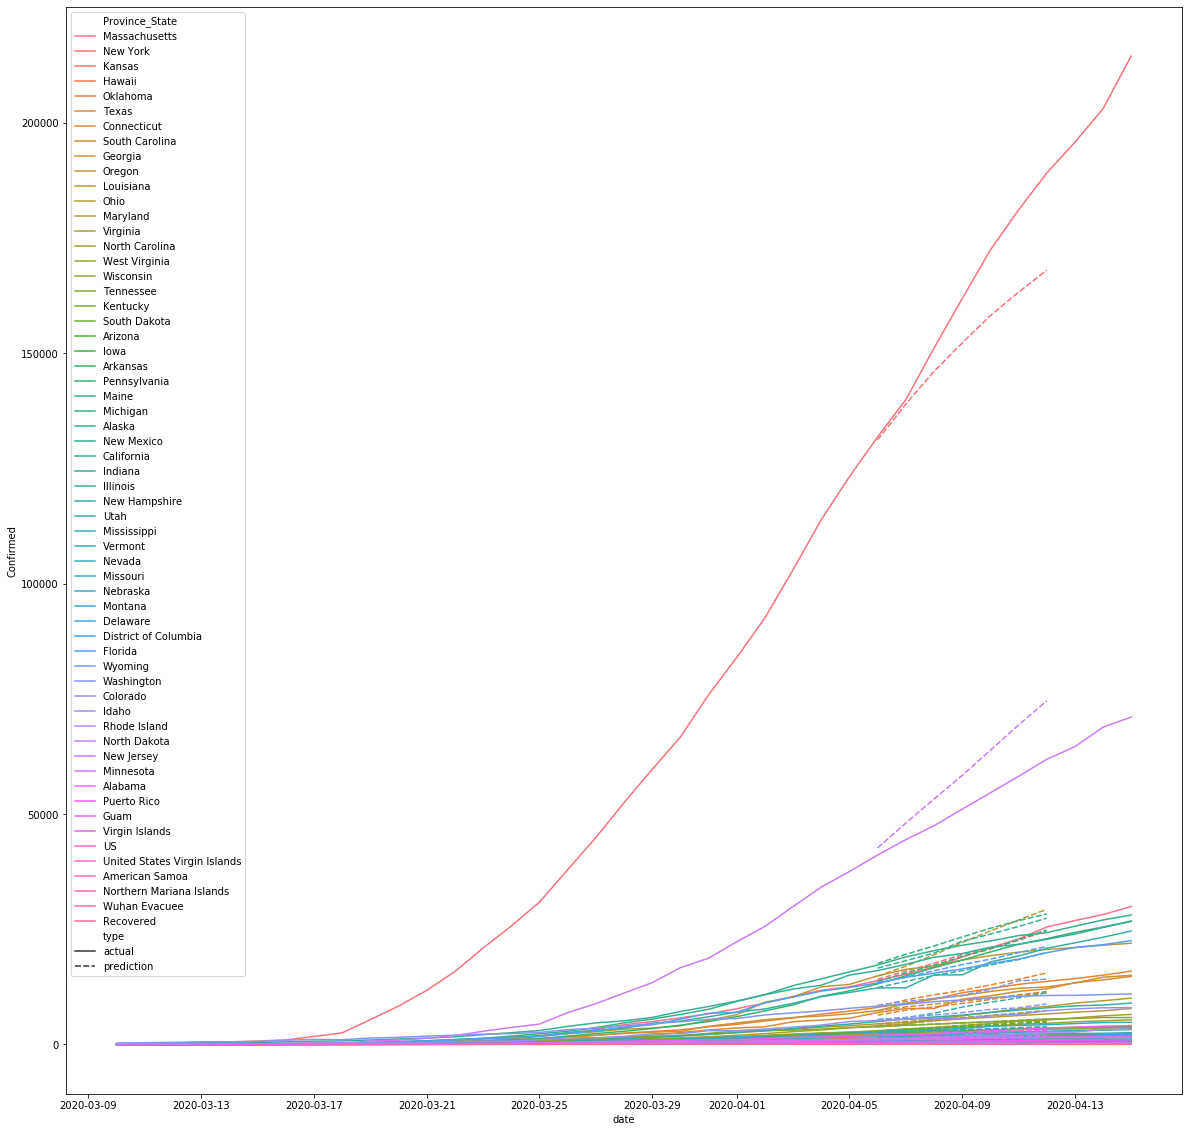

In [32]:
# Combine and format data
combined_state_data = US_state_data[["Province_State", "date", "Confirmed"]]
combined_state_data['date'] = combined_state_data.date.astype('datetime64[ns]')
combined_state_data['type'] = 'actual'
combined_state_data = combined_state_data.append(predict_pd)
combined_state_data = combined_state_data.loc[combined_state_data.date > '03-01-2020']
#combined_state_data = combined_state_data[combined_state_data.Province_State != 'New York']
#combined_state_data = combined_state_data[combined_state_data.Province_State != 'New Jersey']

# Visualize trends
fig, ax1 = plt.subplots(1, 1, figsize=(20,20))

sns.lineplot(x="date", y="Confirmed",
             data=combined_state_data, hue='Province_State', style='type',
             ax=ax1, sort=True)
#ax1.set_yscale('log')

plt.show()

# Aggregate State-Level Predictions to US Country Level

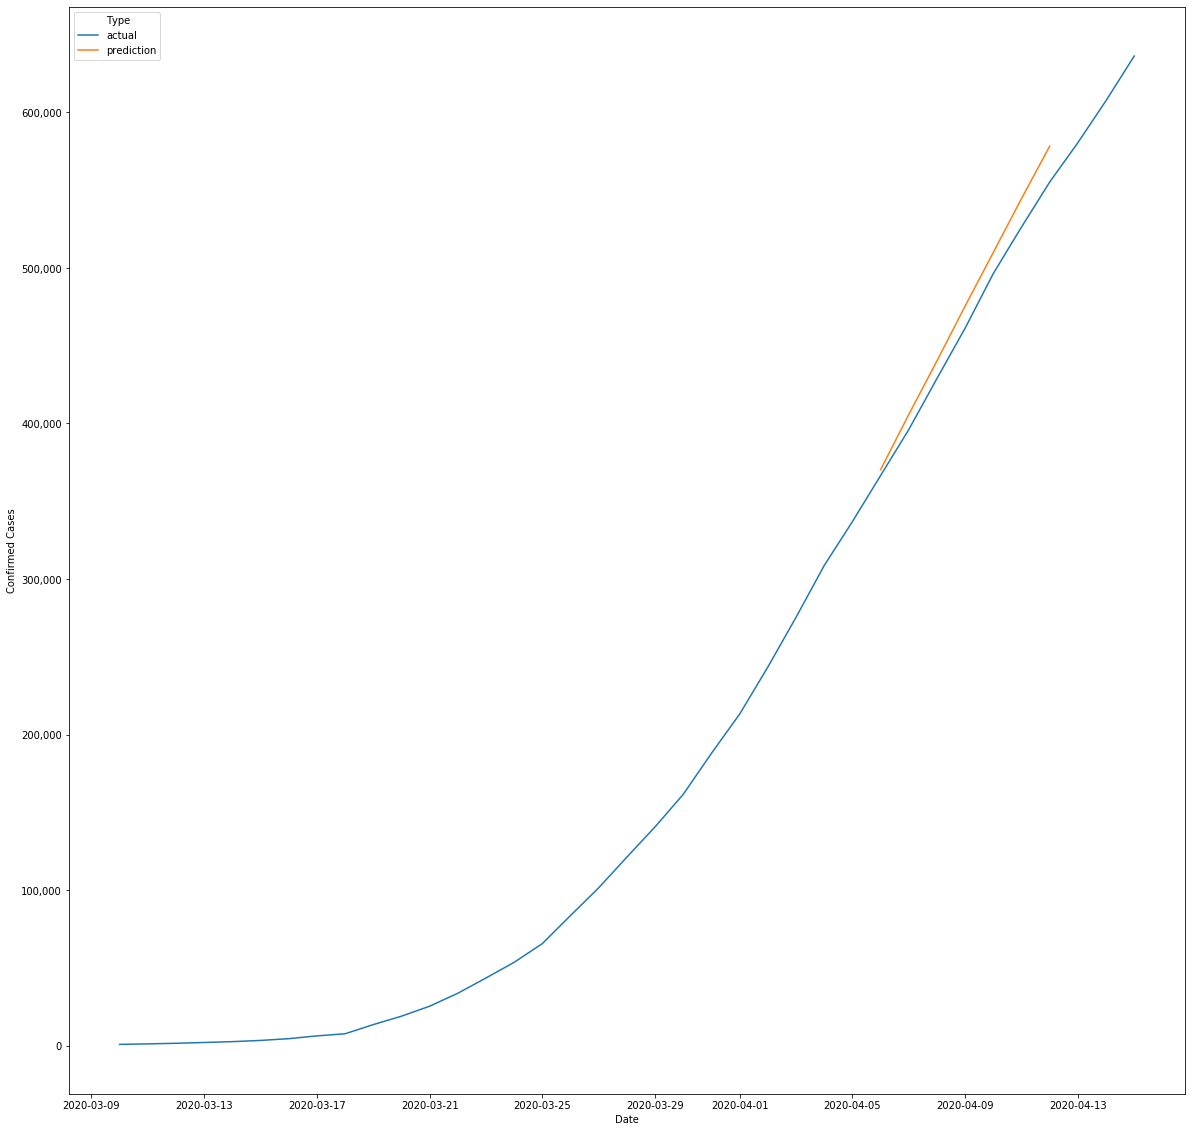

In [33]:
aggregated_chart_pd = US_state_data.groupby('date', as_index = False).agg({'Confirmed': 'sum'})
aggregated_chart_pd['type'] = 'actual'
aggregated_chart_pd['date'] = aggregated_chart_pd['date'].astype('datetime64[ns]')

temp = combined_state_data[combined_state_data.type == 'prediction'].groupby('date', as_index=False).agg({'Confirmed': 'sum'})
temp['type'] = 'prediction'

aggregated_chart_pd = aggregated_chart_pd.append(temp)
aggregated_chart_pd = aggregated_chart_pd[aggregated_chart_pd.date > '03-01-2020']

# Visualize trend
fig, ax1 = plt.subplots(1, 1, figsize=(20,20))

sns.lineplot(x="date", y="Confirmed",
             data=aggregated_chart_pd, hue='type',
             ax=ax1)

ax1.set(xlabel='Date', ylabel='Confirmed Cases')
ax1.legend().texts[0].set_text("Type")
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.0f}'.format(y)))


plt.show()

#aggregated_chart_pd

# Validation

In [34]:
# set up base validation set
predictions = aggregated_chart_pd[aggregated_chart_pd.type == 'prediction']
actuals = aggregated_chart_pd[aggregated_chart_pd.type != 'prediction']
result = actuals.set_index('date').join(predictions.set_index('date'), how='left', rsuffix='_pred')

# worst case prediction based on lag methodology
result['lag'] = result['Confirmed'].shift(1)

# simple prediction based on last daily CAGR
result['CAGR'] = (result['Confirmed'] / result['lag']) - 1
result['prediction_based_on_CAGR'] = (result['CAGR'] + 1) ** 7 * result['Confirmed']
result['prediction_CAGR'] = result['prediction_based_on_CAGR'].shift(7)
result = result[result.Confirmed_pred.notnull()]

result

,Confirmed,type,Confirmed_pred,type_pred,lag,CAGR,prediction_based_on_CAGR,prediction_CAGR
date,,,,,,,,
2020-04-06,366515.0,actual,370257.691023,prediction,336920.0,0.087840,660764.165214,426519.509303
2020-04-07,396071.0,actual,405760.527843,prediction,366515.0,0.080641,681619.624979,540825.407564
2020-04-08,428900.0,actual,440254.039618,prediction,396071.0,0.082887,748922.805954,514274.716782
2020-04-09,461285.0,actual,475479.592541,prediction,428900.0,0.075507,767825.155576,615800.225632
2020-04-10,496383.0,actual,509982.748521,prediction,461285.0,0.076087,829372.952790,653596.027636
2020-04-11,526244.0,actual,544555.533762,prediction,496383.0,0.060157,792098.081853,685774.679957
2020-04-12,555161.0,actual,578226.264974,prediction,526244.0,0.054950,807312.160615,621509.944309


In [35]:
# RMSE
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

print(rmse(result.Confirmed, result.Confirmed_pred))
print(rmse(result.Confirmed, result.lag))
print(rmse(result.Confirmed, result.prediction_CAGR))

14592.40132900779
31249.444431632928
125519.68154181275


# Random Forest Validation

In [36]:
predict_pd = pd.DataFrame()

# fit RF model to every country's confirmed cases and predict future confirmed cases for every state
for day in prediction_days:
    # considered set of days for CAGR
    set_of_days = trending_days + [-day]
    
    # format training data
    training_data = prep_data(nn_data, set_of_days)
    
    # build dictionaries for lookup
    zipped_columns = zip(training_data.index.tolist(), training_data.Country_Region.tolist(), training_data.date.tolist())
    index_to_key = {ind:(loc, date) for ind, loc, date in zipped_columns} 
    key_to_index = {value: key for key, value in index_to_key.items()} 
    
    # train model
    model= train_rf_data(training_data, confirmed_scaler)

    # predict growth rates for each state based on model
    growth_rates_dict = {}
    for state in list_of_states:
        try:
            value = model.predict([test_data.iloc[state_key_to_index[(state, analysis_date)]]])
            growth_rates_dict[state] = value[0]
        except Exception as e: 
            #print("Error: " + str(e))
            continue
    
    # predict confirmed case growth for every state
    for k,v in growth_rates_dict.items():
        t0_confirmed = US_state_data[(US_state_data.Province_State == k) & (US_state_data.date == analysis_date)].Confirmed.values[0]

        append_pd = pd.DataFrame([[analysis_date, k, t0_confirmed * (1+v)**(day), 'prediction']], columns = ['date', 'Province_State', 'Confirmed', 'type'])
        append_pd['date'] = append_pd.date.astype('datetime64[ns]')
        append_pd['date'] = append_pd.apply(lambda row: row.date + timedelta(days=day), axis=1)

        predict_pd = predict_pd.append(append_pd)
            

/opt/anaconda3/envs/plotly/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/anaconda3/envs/plotly/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/anaconda3/envs/plotly/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=Fal

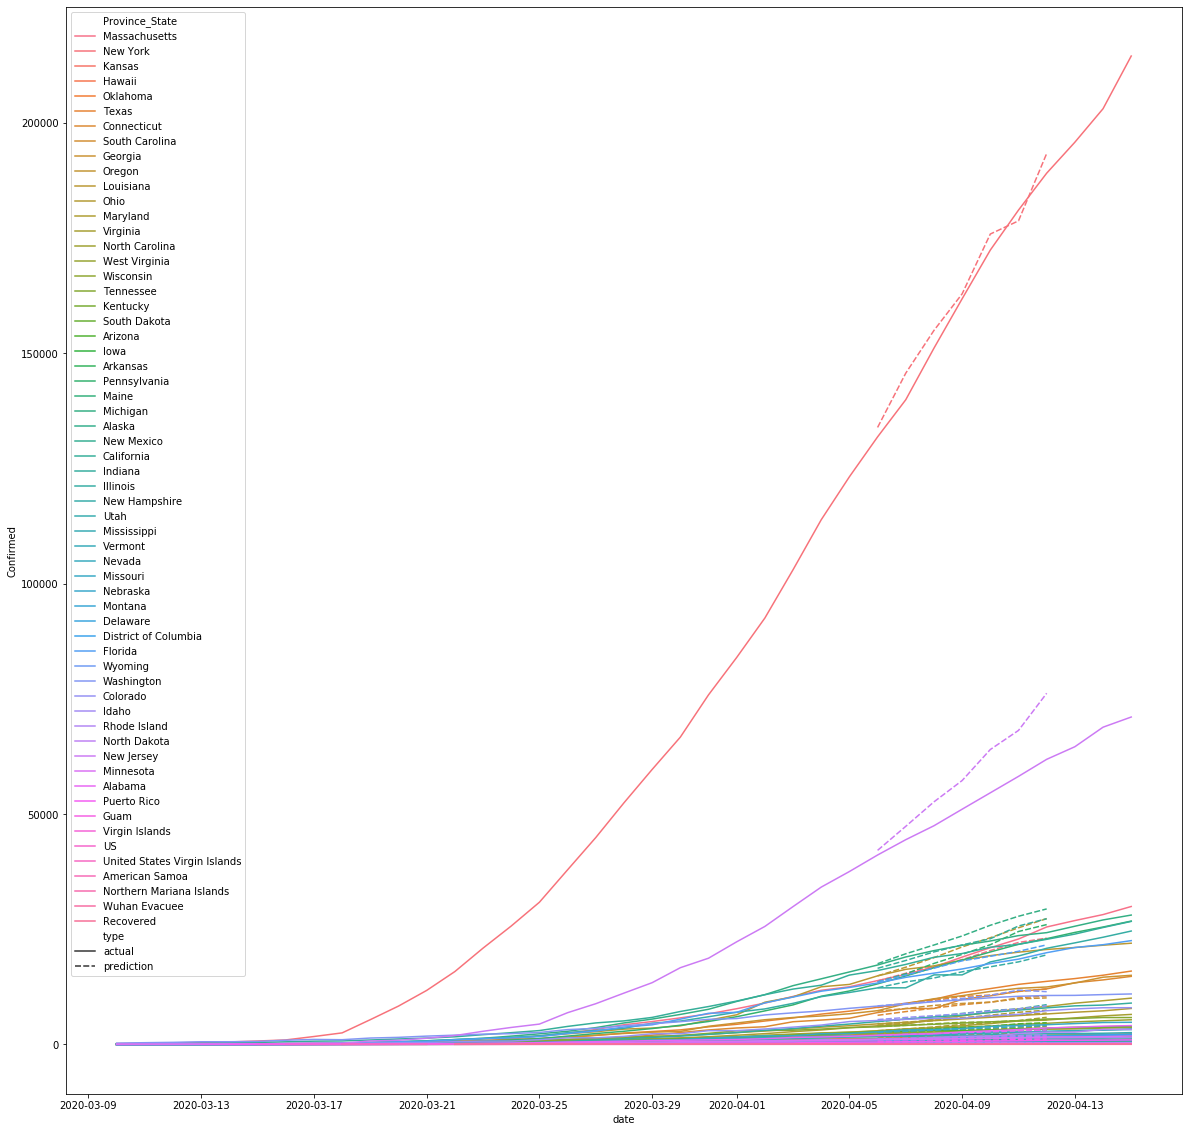

In [37]:
# Combine and format data
combined_state_data = US_state_data[["Province_State", "date", "Confirmed"]]
combined_state_data['date'] = combined_state_data.date.astype('datetime64[ns]')
combined_state_data['type'] = 'actual'
combined_state_data = combined_state_data.append(predict_pd)
combined_state_data = combined_state_data[combined_state_data.date > '03-01-2020']

# Visualize trends
fig, ax1 = plt.subplots(1, 1, figsize=(20,20))

sns.lineplot(x="date", y="Confirmed",
             data=combined_state_data, hue='Province_State', style='type',
             ax=ax1)
#ax1.set_xticklabels(rotation=90, ha='left')

plt.show()

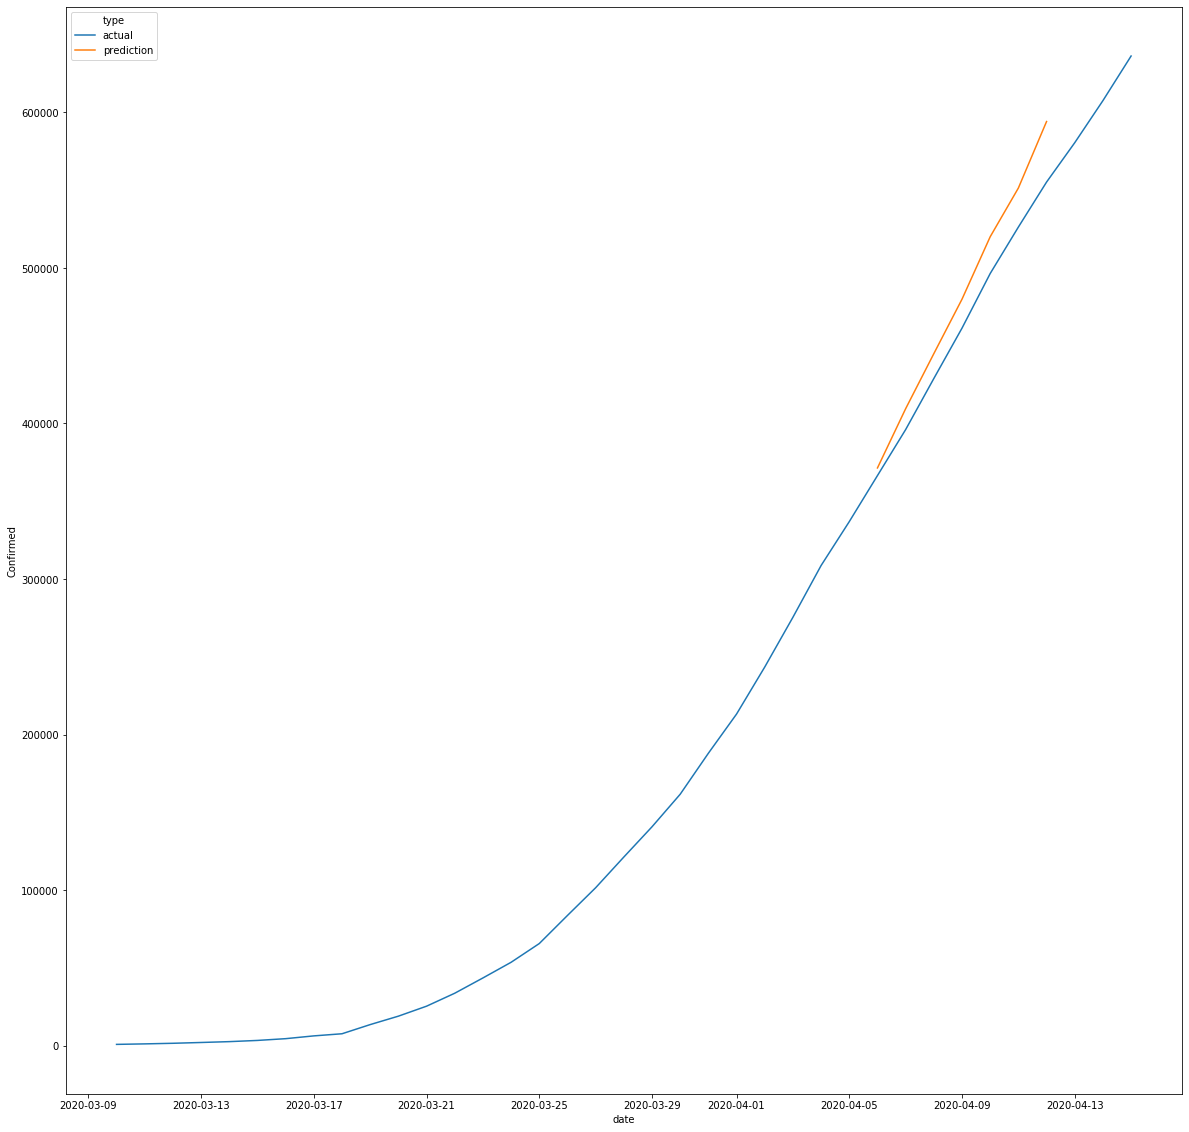

In [38]:
# US Aggregate Visualization
aggregated_chart_pd = US_state_data.groupby('date', as_index = False).agg({'Confirmed': 'sum'})
aggregated_chart_pd['type'] = 'actual'
aggregated_chart_pd['date'] = aggregated_chart_pd['date'].astype('datetime64[ns]')

temp = combined_state_data[combined_state_data.type == 'prediction'].groupby('date', as_index=False).agg({'Confirmed': 'sum'})
temp['type'] = 'prediction'

aggregated_chart_pd = aggregated_chart_pd.append(temp)
aggregated_chart_pd = aggregated_chart_pd[aggregated_chart_pd.date > '03-01-2020']

# Visualize trend
fig, ax1 = plt.subplots(1, 1, figsize=(20,20))

sns.lineplot(x="date", y="Confirmed",
             data=aggregated_chart_pd, hue='type',
             ax=ax1)

plt.show()

In [39]:
# RMSE Validation
predictions = aggregated_chart_pd[aggregated_chart_pd.type == 'prediction']
actuals = aggregated_chart_pd[aggregated_chart_pd.type != 'prediction']
result = actuals.set_index('date').join(predictions.set_index('date'), how='left', rsuffix='_pred')

print(rmse(result.Confirmed, result.Confirmed_pred))

22388.928993792888
